In [1]:
import sys
sys.path.insert(0, '../../')  
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.stats import norm
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from gasp import process_data_for_gasp, create_data_mask, train_gasp, run_gasp, simulate_ssfp, simulate_ssfp_sampling, SSFPParams, responses, simulation, sampling

128


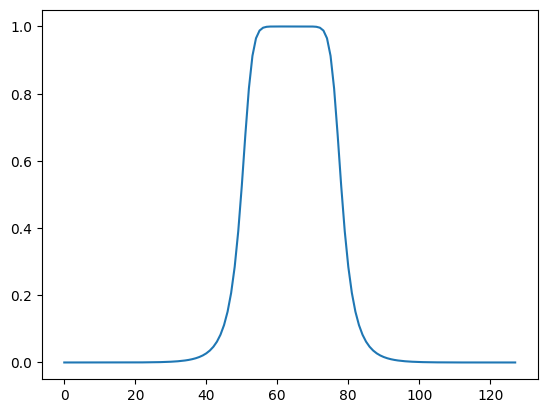

In [2]:
# Parameters
fs = 256  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second of data
N = len(t)
bw = 0.1
lowcut = 64 - bw * fs/2  # Lower cutoff frequency (Hz)
highcut = 64 + bw * fs/2 # Upper cutoff frequency (Hz)

nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq

order=5
b, a = signal.butter(order, [low, high], btype='band')
#b, a = signal.cheby1(order, 1, [low, high], btype='band')
#b, a = signal.ellip(order, 1, 40, [low, high], btype='band')

w, h = signal.freqz(b, a, worN=128)
print(len(h))
plt.plot(0.5 * fs * w / np.pi, np.abs(h))
plt.show()

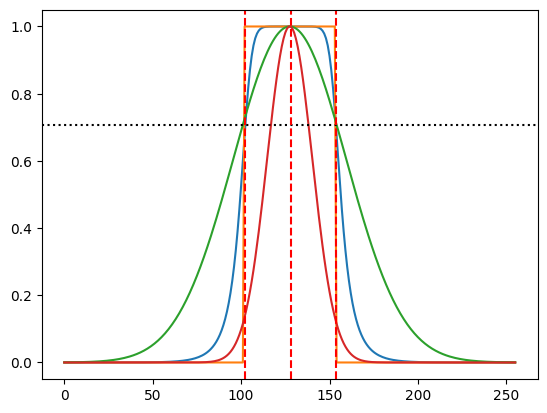

In [3]:
width = 256
D = responses.basspass_filter(width, 0.1, 0)
plt.plot(D) 
D2 = responses.square(width, 0.2, 0)
plt.plot(D2) 
D3 = responses.gaussian(width, 0.5, 0)
plt.plot(D3) 
D4 = responses.gaussian(width, 0.2, 0)
plt.plot(D4) 

_3db = 10 ** (-3/20)
plt.axhline(_3db, color='k', linestyle=':', label='-3 dB Line')
plt.axvline(width / 2, color='r', linestyle='--', label='Design Lowcut')

shift = 0
fs = width * 2  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second of data
lowcut =  width * (1/2 - bw + shift) # Lower cutoff frequency (Hz)
highcut = width * (1/2 + bw + shift) # Upper cutoff frequency (Hz)
plt.axvline(lowcut, color='r', linestyle='--', label='Design Lowcut')
plt.axvline(highcut, color='r', linestyle='--', label='Design Lowcut')

plt.show()

In [14]:
def plot_RMSE(D, sampling_schemes, alpha=np.deg2rad(60), width = 128):
    n_points = np.linspace(6, 48, 48-6, endpoint=False).astype(np.int64) 
    RMSE = np.zeros((len(sampling_schemes), len(n_points)))
    PSNR = np.zeros((len(sampling_schemes), len(n_points)))
    SSIM = np.zeros((len(sampling_schemes), len(n_points)))

    for i, scheme in enumerate(sampling_schemes):
        for j, n in enumerate(n_points):
            TRs, PCs = scheme[1](n)
            params = SSFPParams(n, alpha, TRs, PCs)
            M = simulate_ssfp_sampling(width=width, height=1, params=params, minTR = np.min(params.TRs), gradient = 2 * np.pi, phantom_type='line')
            Ic, An = train_gasp(M, D)
            
            original = np.abs(D)
            filtered = np.abs(Ic[0])

            # Root Mean Squared Error (RMSE)
            RMSE[i, j] = np.sqrt(np.mean((original - filtered)**2))
            # Peak Signal-to-Noise Ratio (PSNR)
            val_min = original.min()
            val_range = original.max() - val_min
            # normalize the original to range [0.0, 1.0]
            original_normed = (original - val_min) / val_range
            # apply identical normalization to the denoised image (important!)
            filtered_normed = (filtered - val_min) / val_range
            PSNR[i, j] = psnr(original_normed, filtered_normed)
            # Structural Similarity Index (SSIM)
            SSIM[i, j] = ssim(original, filtered, data_range=original.max() - original.min())
    
    plt.figure(1)
    plt.plot(n_points, RMSE.T)
    plt.figure(2)
    plt.plot(n_points, PSNR.T)
    plt.figure(3)
    plt.plot(n_points, SSIM.T)


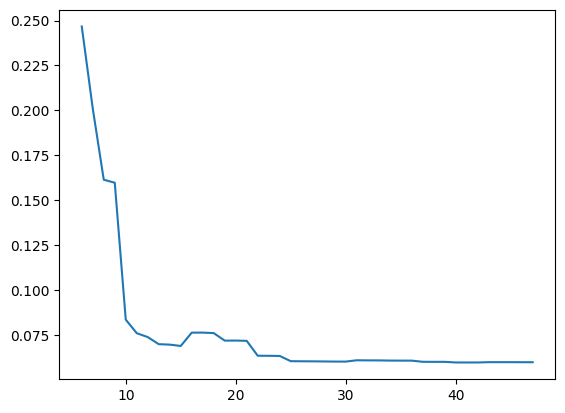

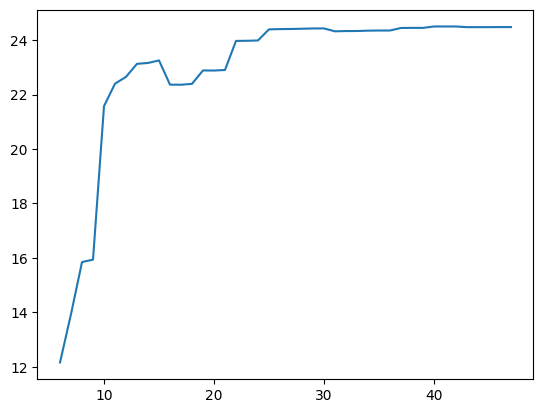

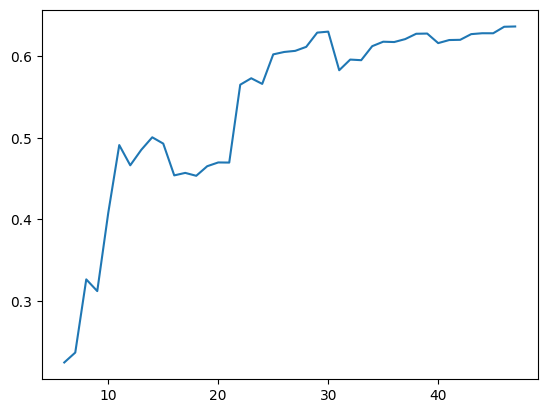

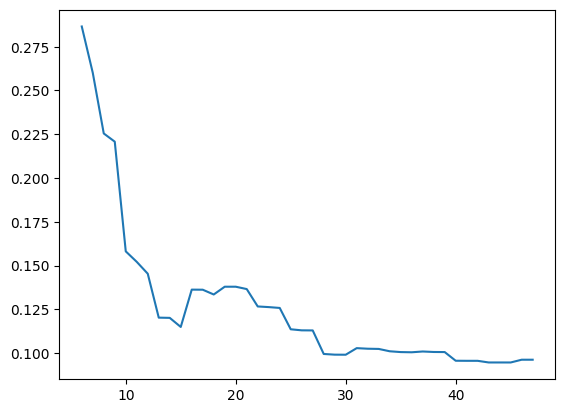

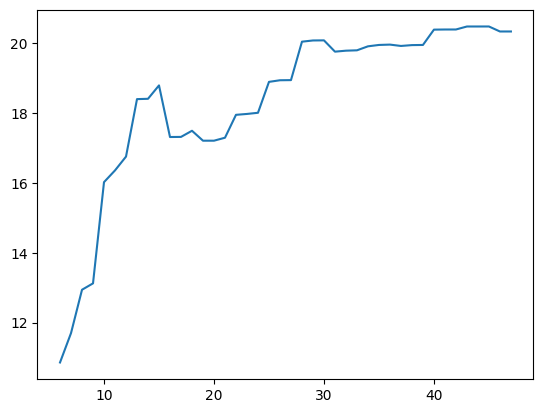

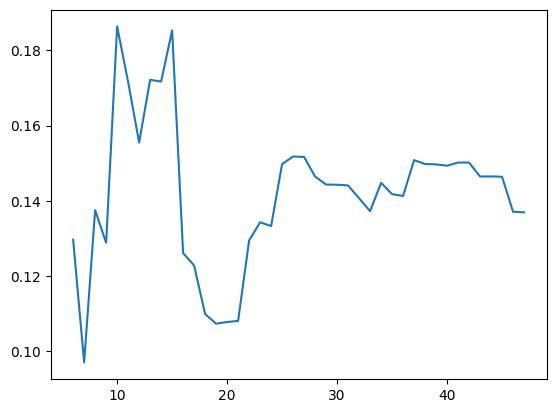

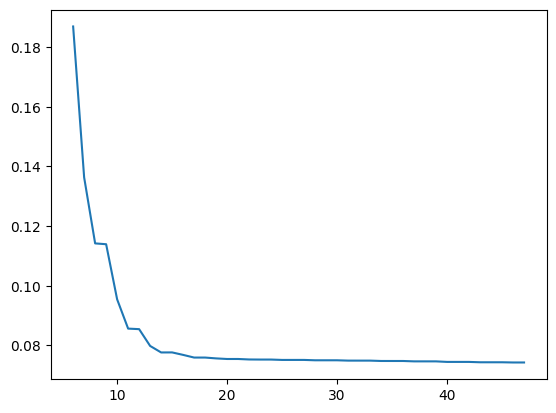

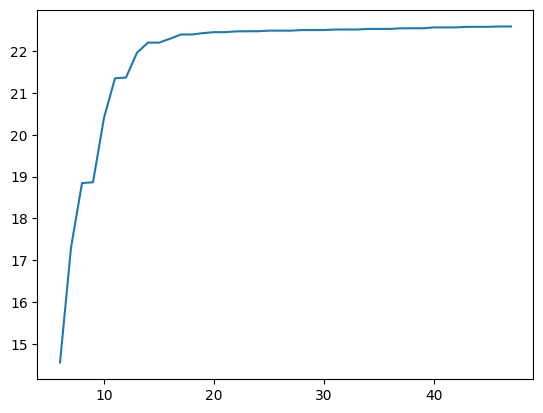

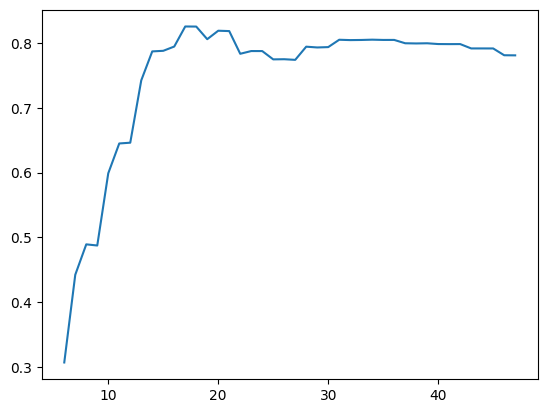

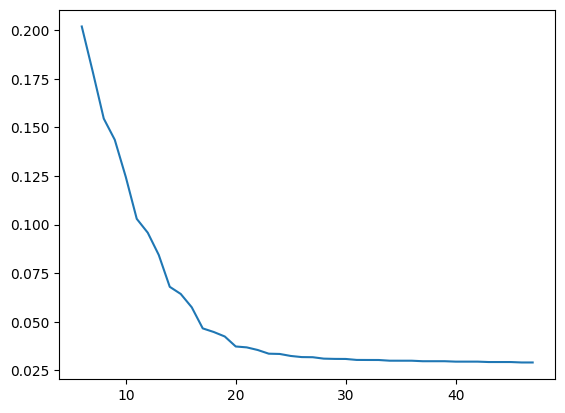

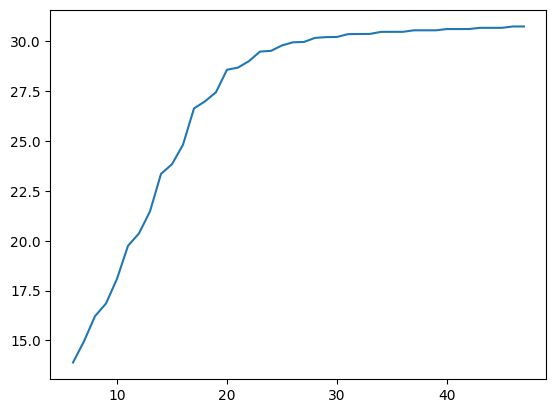

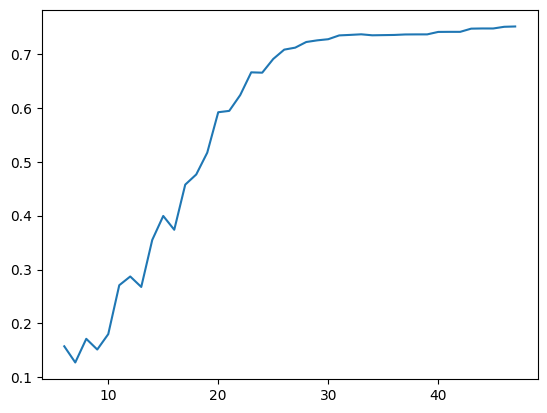

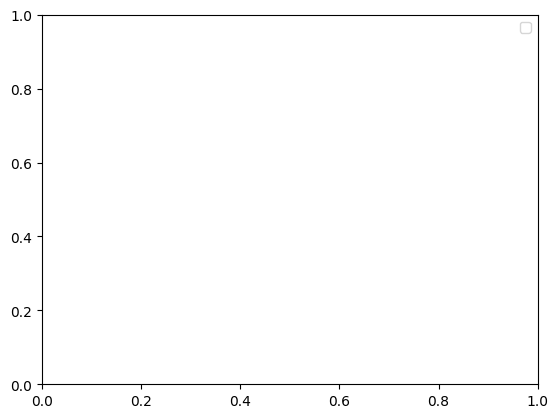

In [15]:
alpha = np.deg2rad(30)
tr_range = (5e-3, 20e-3)

sampling_schemes = [
    ('grid_TR', lambda n: sampling.grid_TR_sampling(n_points=n, TRs=[5e-3, 10e-3, 20e-3])),
]

plot_RMSE(D, sampling_schemes, alpha=alpha, width=width)
plot_RMSE(D2, sampling_schemes, alpha=alpha, width=width)
plot_RMSE(D3, sampling_schemes, alpha=alpha, width=width)
plot_RMSE(D4, sampling_schemes, alpha=alpha, width=width)

plt.legend(['bandpass','square','gaussian', 'gaussian-sm'])
plt.show()